## Deriving the transfer function of the Simper SVF filter structure

HTML output built with: jupyter nbconvert --to html svf_z_domain_tf.ipynb

Source:
https://cytomic.com/files/dsp/SvfLinearTrapOptimised2.pdf

We will follow the second form of the algorithm, found on page 6.

Sympy can't (very easily) be bent to display transfer functions in terms of $z^{-1}, z^{-2}, ...$ which is the convention. Plain $z$ will be used here instead - keep in mind it actually means $z^{-1}$.

In [1]:
from sympy import *
init_printing()
.
z = symbols("z")

/opt/anaconda/lib/python3.8/site-packages/mpmath/ctx_mp_python.py:892: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if other is 0:
/opt/anaconda/lib/python3.8/site-packages/mpmath/ctx_mp_python.py:986: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if other is 0:


Start with the parameters.

```
g = Tan[π * cutoff / samplerate];
k = 1/Q = 2 - 2*res;
a1 = 1/(1 + g*(g + k));
a2 = g*a1;
```

The other coefficients defining the shape of the filter (`m0, m1, m2`) will be ignored for now, as they are only used to "mix" the output.

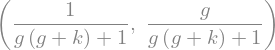

In [2]:
g, k = symbols("g k")
a1 = 1/(1 + g*(g + k))
a2 = g*a1

(a1, a2)

Then the computation.

The variable `v0` represents the input signal - we will consider it to represent the z-transform of the input over time. `v1` and `v2` represent two other nodes in the block diagram.

The state variables `ic1eq` and `ic2eq` will be defined as unknowns first, and then we will solve them using their equations.

The relevant lines of the algorithm are:

```
v1 = a1 * ic1eq + a2 * (v0 - ic2eq);
v2 = ic2eq + g * v1;
```

Notice that the `ic1eq` and `ic2eq` actually refer to the _previous_ values of these samples. This corresponds to multiplying by $z$ (contrary to convetion!) in the z-domain.

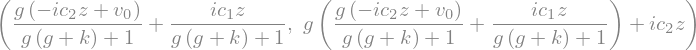

In [3]:
v0, ic1eq, ic2eq = symbols("v0 ic_1 ic_2")

v1 = a1 * ic1eq * z + a2 * (v0 - ic2eq * z)
v2 = ic2eq * z + g * v1

(v1, v2)

The "new" values for `ic1eq, ic2eq` are computed as follows:

```
ic1eq = 2*v1 - ic1eq;
ic2eq = 2*v2 - ic2eq;
```

depending on the current values of `v1, v2`, and the previous values of `ic1eq, ic2eq`.

Consider this as a system of equations, and solve it:

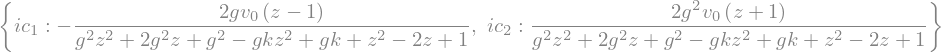

In [4]:
equations = [
    2*v1 - ic1eq * z - ic1eq, # = 0
    2*v2 - ic2eq * z - ic2eq, # = 0
]
solution = solve(equations, (ic1eq, ic2eq))

solution

We may now subsitute the solution into `v1` and `v2` to obtain the transfer functions

$$
\begin{aligned}
H_0(z) &= \frac {v_0(z)} {v_0(z)} = 1  \\
H_1(z) &= \frac {v_1(z)} {v_0(z)} \\
H_2(z) &= \frac {v_2(z)} {v_0(z)}
\end{aligned}
$$

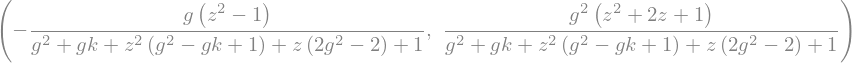

In [5]:
H0 = 1
H1 = v1.subs(solution) / v0
H2 = v2.subs(solution) / v0

H1 = collect(simplify(H1), z)
H2 = collect(simplify(H2), z)

(H1, H2)

How convenient, the denominators seem to be the same! That is to be expected of course,
since taking linear combinations of $H_1, H_2$ cannot result in anything that has more than two poles, because the order of the system is 2.

In [6]:
(H1_num, H1_denom) = fraction(H1)
(H2_num, H2_denom) = fraction(H2)

assert H1_denom == H2_denom
denom = H1_denom
denom

We can now assemble the complete transfer function, taking into account the mix coefficients `m0, m1, m2`.

$$
H(z) = m_0 H_0(z) + m_1 H_1(z) + m_2 H_2(z)
$$

m0 + (g**2*m2*(z**2 + 2*z + 1) - g*m1*(z**2 - 1))/(g**2 + g*k + z**2*(g**2 - g*k + 1) + z*(2*g**2 - 2) + 1)


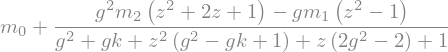

In [7]:
m0, m1, m2 = symbols("m0 m1 m2")

H = m0 * H0 + (m1 * H1_num + m2 * H2_num) / denom

print(H)
H

## Sanity check: High pass filter

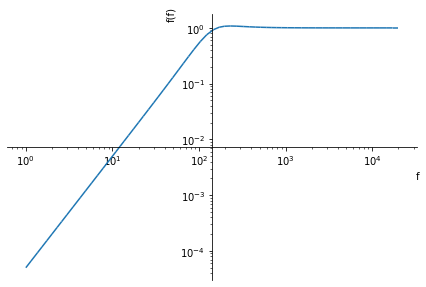

In [8]:
from sympy.functions import tan, exp

samplerate = 40_000
cutoff = sqrt(samplerate/2)
Q = 0.9

f = symbols("f")

H_hp_f = H.subs({
    g: tan(pi * cutoff / samplerate),
    k: 1/Q,
    m0: 1,
    m1: -1/Q, # = -k
    m2: -1,
    z: exp(2*I*pi * f / samplerate)**-1,
})

plot(abs(H_hp_f), (f, 1, samplerate/2), xscale='log', yscale='log')